In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/MUFG2023"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error
from sklearn.metrics import f1_score, accuracy_score

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler

In [5]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test.csv"))
card = pd.read_csv(os.path.join(INPUT_DIR, "card.csv"))
user = pd.read_csv(os.path.join(INPUT_DIR, "user.csv"))
sub = pd.read_csv(os.path.join(INPUT_DIR, "sample_submit.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(card.shape)
display(card.head(3))

print(user.shape)
display(user.head(3))

print(sub.shape)
display(sub.head(3))

(471283, 12)


,index,user_id,card_id,amount,errors?,is_fraud?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,0,1721,0,$2.623,OK,0,209237,Joliet,IL,60436.0,5541,Swipe Transaction
1,1,1629,3,$6.4,OK,0,2568,Edgerton,WI,53534.0,5814,Swipe Transaction
2,2,655,3,$123.5,OK,0,345310,Ridgefield,WA,98642.0,7538,Swipe Transaction


(457958, 11)


,index,user_id,card_id,amount,errors?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,471283,541,3,$113.278,OK,324189,Orlando,FL,32821.0,4814,Swipe Transaction
1,471284,655,1,$293.944,OK,81219,Ridgefield,WA,98642.0,7538,Chip Transaction
2,471285,492,0,$47.4,OK,274755,Arlington Heights,IL,60004.0,5719,Swipe Transaction


(416, 10)


,user_id,card_id,card_brand,card_type,expires,has_chip,cards_issued,credit_limit,acct_open_date,year_pin_last_changed
0,39,0,Visa,Debit,09/2021,YES,1,$17117,05/2007,2010
1,39,1,Amex,Credit,11/2024,YES,2,$5400,10/2015,2015
2,41,0,Discover,Credit,03/2022,YES,2,$14800,12/2010,2011


(97, 17)


,user_id,current_age,retirement_age,birth_year,birth_month,gender,address,city,state,zipcode,latitude,longitude,per_capita_income_zipcode,yearly_income_person,total_debt,fico_score,num_credit_cards
0,39,57,64,1962,12,Female,442 Burns Boulevard,Mansfield,MA,2048,42.02,-71.21,$37407,$76274,$102611,698,2
1,41,39,66,1980,10,Female,3863 River Avenue,Lincoln,CA,95648,38.93,-121.25,$21829,$44506,$57994,849,3
2,47,40,67,1979,5,Female,8799 Elm Avenue,Mckinney,TX,75069,33.20,-96.65,$24684,$50329,$76759,625,4


(457958, 2)


,0,1
0,471283,0
1,471284,1
2,471285,0


In [6]:
month_dict = {
   "01": 1,
   "02": 2,
   "03": 3,
   "04": 4,
   "05": 5,
   "06": 6,
   "07": 7,
   "08": 8,
   "09": 9,
   "10": 10,
   "11": 11,
   "12": 12
}

def get_expires_values(df):
  _df = df["expires"].str.split('/').apply(pd.Series)
  _df.columns = ["month","years"]
  df["expires_month"] = _df["month"].astype(str)
  df["expires_years"] = _df["years"].astype(int)
  return df

def get_acct_open_date_values(df):
  _df = df["acct_open_date"].str.split('/').apply(pd.Series)
  _df.columns = ["month","years"]
  df["acct_open_date_month"] = _df["month"].astype(str)
  df["acct_open_date_years"] = _df["years"].astype(int)
  return df


card = get_expires_values(card)
card = get_acct_open_date_values(card)
card["expires_month"] = card["expires_month"].map(month_dict)
card["acct_open_date_month"] = card["acct_open_date_month"].map(month_dict)

In [7]:
card["credit_limit"] = card["credit_limit"].astype(str).str.extract("(\d+)").astype("float32")
user["per_capita_income_zipcode"] = user["per_capita_income_zipcode"].astype(str).str.extract("(\d+)").astype("float32")
user["yearly_income_person"] = user["yearly_income_person"].astype(str).str.extract("(\d+)").astype("float32")
user["total_debt"] = user["total_debt"].astype(str).str.extract("(\d+)").astype("float32")

In [8]:
train["amount"] = train["amount"].astype(str).str.extract("(\d+)").astype("float32")
test["amount"] = test["amount"].astype(str).str.extract("(\d+)").astype("float32")

In [9]:
for col in ["user_id", "card_id", "mcc", "use_chip", "errors?"]:
  train = pd.concat([train, pd.get_dummies(train[col], prefix=f"{col}").astype(np.uint8)], axis=1)
  test = pd.concat([test, pd.get_dummies(test[col], prefix=f"{col}").astype(np.uint8)], axis=1)

In [10]:
for col in ["card_type", "card_brand", "has_chip"]:
  card = pd.concat([card, pd.get_dummies(card[col], prefix=f"{col}").astype(np.uint8)], axis=1)

In [11]:
for col in ["gender", "state"]:
  user = pd.concat([user, pd.get_dummies(user[col], prefix=f"{col}").astype(np.uint8)], axis=1)

In [12]:
concat_data = pd.concat([train,test],axis=0)
concat_data = concat_data.merge(card, how="left", on=["user_id", "card_id"]).merge(user, how="left", on="user_id")

concat_data = concat_data.fillna("NAN")

In [13]:
city_c = concat_data["merchant_city"].value_counts(normalize=True).to_dict()
state_c = concat_data["merchant_state"].value_counts(normalize=True).to_dict()

concat_data["city_c"] = concat_data["merchant_city"].map(lambda x: city_c[x]).values
concat_data["state_c"] = concat_data["merchant_state"].map(lambda x: state_c[x]).values

concat_data.loc[concat_data["city_c"]<0.0005, "merchant_city"] = "Rare_city"
concat_data.loc[concat_data["state_c"]<0.0005, "merchant_state"] = "Rare_state"

In [14]:
for col in ["merchant_state"]:
  concat_data = pd.concat([concat_data, pd.get_dummies(concat_data[col], prefix=f"{col}").astype(np.uint8)], axis=1)

In [15]:
train_df = concat_data.iloc[:train.shape[0],:]
train_df = train_df.reset_index(drop=True)
test_df = concat_data.iloc[train.shape[0]:,:]
test_df = test_df.reset_index(drop=True)

In [16]:
ori_categorical_features = ["user_id", "card_id", "errors?", "merchant_id", "merchant_city", "merchant_state", "mcc", "use_chip",
                        "card_brand", "card_type", "has_chip", "gender", "city", "state",
                        "birth_month",
                        ]

In [17]:
def preprocess_func(train_data, valid_data, test_data):
  drop_list = ["index", "zip", "zipcode", "expires", "acct_open_date", "expires_month", "acct_open_date_month", "address", "fold", "city_c", "state_c", "is_fraud?"] + ori_categorical_features
  train_data.drop(drop_list, axis=1, inplace=True)
  valid_data.drop(drop_list, axis=1, inplace=True)
  test_data.drop(drop_list, axis=1, inplace=True)

  train_data = train_data.replace("NAN", -1)
  train_data = train_data.fillna(-1)
  valid_data = valid_data.replace("NAN", -1)
  valid_data = valid_data.fillna(-1)
  test_data = test_data.replace("NAN", -1)
  test_data = test_data.fillna(-1)

  scaler = StandardScaler()
  scaler.fit(train_data)
  train_data = scaler.transform(train_data)
  valid_data = scaler.transform(valid_data)
  test_data = scaler.transform(test_data)
  return train_data, valid_data, test_data

In [18]:
class CFG:
  debug=False
  ver=59
  model="knn"
  n_folds=5
  trn_fold=[0, 1, 2, 3, 4]
  seed=42
  target="is_fraud?"
  n_neighbors=8

In [19]:
train_df[CFG.target] = train_df[CFG.target].astype(int)
skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
for fold, (train_index, valid_index) in enumerate(skf.split(train_df, train_df[CFG.target])):
    train_df.loc[valid_index, "fold"] = fold
train_df['fold'] = train_df['fold'].astype(int)
display(train_df.groupby('fold').size())

fold
0    94257
1    94257
2    94257
3    94256
4    94256
dtype: int64

In [20]:
if CFG.debug:
    display(train_df.groupby('fold').size())
    train_df = train_df.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train_df.groupby('fold').size())

In [21]:
from sklearn.neighbors import KNeighborsClassifier

oof_df = pd.DataFrame()
test_preds = []
test_df["fold"] = 999

for fold in range(CFG.n_folds):
  if fold in CFG.trn_fold:
    print("="*15,f" FOLD : {fold} ","="*15)
    train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)
    df_test = test_df.copy()

    train_labels = train_folds[CFG.target]
    valid_labels = valid_folds[CFG.target]
    train_X, valid_X, test_X = preprocess_func(train_folds, valid_folds, df_test)


    model = KNeighborsClassifier(n_neighbors=CFG.n_neighbors)
    model.fit(train_X, train_labels)

    valid_folds["pred"] = model.predict_proba(valid_X)[:, 1]
    test_pred = model.predict_proba(test_X)[:, 1]
    test_preds.append(test_pred)
    valid_folds[CFG.target] = valid_labels
    oof_df = pd.concat([oof_df, valid_folds])

    validy_pred = np.where(valid_folds["pred"]>0.5, 1, 0)
    scoref1 =  f1_score(valid_labels, validy_pred)
    scoreacc = accuracy_score(valid_labels, validy_pred)
    print(f"F1 Score : {scoref1}")

===============  FOLD : 0  ===============
F1 Score : 0.5452191235059761
===============  FOLD : 1  ===============
F1 Score : 0.5481055346161475
===============  FOLD : 2  ===============
F1 Score : 0.5493417796694051
===============  FOLD : 3  ===============
F1 Score : 0.5428087311870826
===============  FOLD : 4  ===============
F1 Score : 0.5455809334657398


In [22]:
f1score =  f1_score(oof_df[CFG.target], np.where(oof_df["pred"]>0.5,1,0))
print(f'CV F1 Score: {f1score}')

CV F1 Score: 0.5462168176760452


In [23]:
best_score = 0
best_thresh = 0.5
for thresh in np.arange(0.15, 0.65, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(oof_df[CFG.target], (oof_df["pred"]>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score:
      best_score = score
      best_thresh = thresh
print()
print("best F1 score at threshold {0} is {1}".format(best_thresh, f1_score(oof_df[CFG.target], (oof_df["pred"]>best_thresh).astype(int))))

F1 score at threshold 0.15 is 0.5167532435559714
F1 score at threshold 0.16 is 0.5167532435559714
F1 score at threshold 0.17 is 0.5167532435559714
F1 score at threshold 0.18 is 0.5167532435559714
F1 score at threshold 0.19 is 0.5167532435559714
F1 score at threshold 0.2 is 0.5167532435559714
F1 score at threshold 0.21 is 0.5167532435559714
F1 score at threshold 0.22 is 0.5167532435559714
F1 score at threshold 0.23 is 0.5167532435559714
F1 score at threshold 0.24 is 0.5167532435559714
F1 score at threshold 0.25 is 0.570673586607383
F1 score at threshold 0.26 is 0.570673586607383
F1 score at threshold 0.27 is 0.570673586607383
F1 score at threshold 0.28 is 0.570673586607383
F1 score at threshold 0.29 is 0.570673586607383
F1 score at threshold 0.3 is 0.570673586607383
F1 score at threshold 0.31 is 0.570673586607383
F1 score at threshold 0.32 is 0.570673586607383
F1 score at threshold 0.33 is 0.570673586607383
F1 score at threshold 0.34 is 0.570673586607383
F1 score at threshold 0.35 is 0.

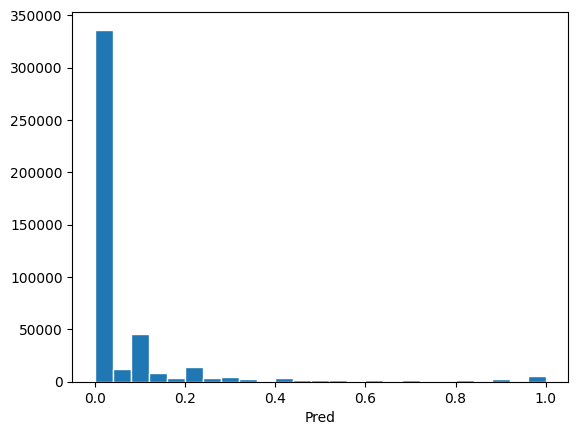

,index,is_fraud?
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0
...,...,...
457953,929236,0
457954,929237,0
457955,929238,0
457956,929239,0


0    422745
1     35213
Name: is_fraud?, dtype: int64

In [24]:
submit = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
submit.columns = ["index","pred"]
pred = np.mean(test_preds, axis=0)
submit['pred'] = pred
submit[CFG.target] = (pred>best_thresh).astype(int)
submit[f"pred0{CFG.ver}_fold0"] = test_preds[0]
submit[f"pred0{CFG.ver}_fold1"] = test_preds[1]
submit[f"pred0{CFG.ver}_fold2"] = test_preds[2]
submit[f"pred0{CFG.ver}_fold3"] = test_preds[3]
submit[f"pred0{CFG.ver}_fold4"] = test_preds[4]


submit[["index","is_fraud?"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)


plt.hist(pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(submit[["index","is_fraud?"]])
display(submit[CFG.target].value_counts())

In [25]:
OOF_DIR = os.path.join(OUTPUT_DIR, 'oof')

if not os.path.exists(OOF_DIR):
    os.makedirs(OOF_DIR)

oof_df.to_csv(os.path.join(OOF_DIR, f'oof_{CFG.model}_ver{CFG.ver}.csv'))

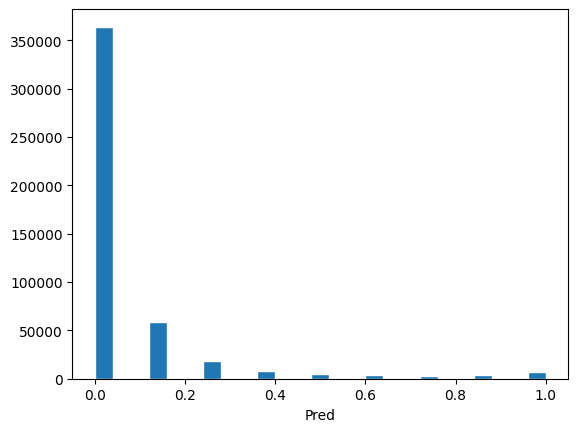

In [26]:
plt.hist(oof_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

In [27]:
SUB_NUM_DIR = os.path.join(OUTPUT_DIR, 'sub_num')

if not os.path.exists(SUB_NUM_DIR):
    os.makedirs(SUB_NUM_DIR)


submit.to_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG.model}_ver{CFG.ver}.csv'), index=False)
display(submit.head())

,index,pred,is_fraud?,pred059_fold0,pred059_fold1,pred059_fold2,pred059_fold3,pred059_fold4
0,471283,0.000,0,0.000,0.00,0.000,0.000,0.000
1,471284,0.050,0,0.000,0.00,0.000,0.125,0.125
2,471285,0.025,0,0.125,0.00,0.000,0.000,0.000
3,471286,0.300,1,0.125,0.25,0.125,0.500,0.500
4,471287,0.000,0,0.000,0.00,0.000,0.000,0.000
